In [ ]:
!pip install yfinance pandas numpy matplotlib


MSFT Close vector has 250 points from 2023-01-03 00:00:00-05:00 to 2023-12-29 00:00:00-05:00


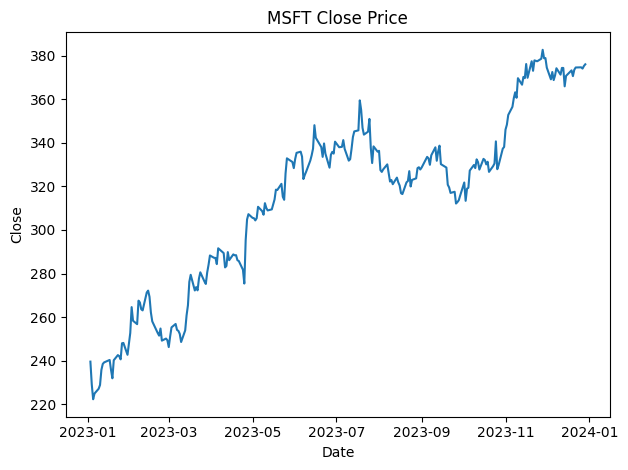

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from typing import Tuple, Dict

def download_stock_history(
    ticker: str,
    start: str,
    end: str,
    interval: str = "1d",
    column: str = "Adj Close",
) -> Dict[str, np.ndarray]:
    """
    Download historical stock data for `ticker` between `start` and `end` (inclusive)
    using yfinance. Returns a dict of numpy arrays:
      - dates: datetime64 array
      - open, high, low, close, adj_close, volume
      - vector: the requested column as a numpy array (e.g., 'Adj Close')

    Parameters:
        ticker: Stock symbol, e.g. "AAPL"
        start: Start date in "YYYY-MM-DD"
        end: End date in "YYYY-MM-DD"
        interval: Data interval, e.g. "1d", "1wk", "1mo"
        column: Which column to expose as the main vector ("Adj Close" by default)

    Raises:
        ValueError if dates are invalid or no data is returned.
    """
    # Parse and validate dates
    start_ts = pd.to_datetime(start)
    end_ts = pd.to_datetime(end)
    if end_ts < start_ts:
        raise ValueError("end date must not be before start date")

    # Fetch data
    df = yf.Ticker(ticker).history(
        start=start_ts.strftime("%Y-%m-%d"),
        end=end_ts.strftime("%Y-%m-%d"),
        interval=interval,
        auto_adjust=False,  # keep raw columns so we can expose both Close and Adj Close
    )

    if df.empty:
        raise ValueError(f"No data fetched for ticker '{ticker}' in range {start} to {end}")

    # Ensure requested column exists
    if column not in df.columns:
        raise ValueError(f"Requested column '{column}' not in data; available columns: {list(df.columns)}")

    # Build output numpy arrays
    out: Dict[str, np.ndarray] = {
        "dates": df.index.to_numpy(),
        "open": df["Open"].to_numpy(),
        "high": df["High"].to_numpy(),
        "low": df["Low"].to_numpy(),
        "close": df["Close"].to_numpy(),
        "adj_close": df["Adj Close"].to_numpy() if "Adj Close" in df.columns else df["Close"].to_numpy(),
        "volume": df["Volume"].to_numpy(),
        "vector": df[column].to_numpy(),
    }
    return out


def get_price_vector(
    ticker: str,
    start: str,
    end: str,
    interval: str = "1d",
    column: str = "Adj Close",
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Convenience wrapper that returns (vector, dates) for the requested column.
    """
    data = download_stock_history(ticker, start, end, interval, column)
    return data["vector"], data["dates"]


# Example usage
if __name__ == "__main__":
    import matplotlib.pyplot as plt

    ticker = "MSFT"
    start_date = "2023-01-01"
    end_date = "2023-12-31"
    column = "Close"

    vector, dates = get_price_vector(ticker, start_date, end_date, column=column)
    print(f"{ticker} {column} vector has {len(vector)} points from {dates[0]} to {dates[-1]}")

    # Simple plot (requires matplotlib)
    plt.plot(dates, vector)
    plt.title(f"{ticker} {column} Price")
    plt.xlabel("Date")
    plt.ylabel(column)
    plt.tight_layout()
    plt.show()
